## Homework
Try to find the letters on the number plates. Please note, that any other route is possible, I even encourage you to try to find better methods if you have the ambition.
By the end of the class after thresholding and looking for horizontal patches you should end up with about two dozen of them matching the criteria. Go through them and perform the following:
* Use k-means clustering with k=2 on these rectangles. If the original patch was a number plate we expect this to find letters and other dirt. Let us call smallpatches these patches found on the patches.
* Discard smallpatches which:
   - are larger than 1/5th of the patch
   - are smaller than 1/100th of the patch
   - are shorter than the half of the patch (in the vertical direction)
   - have an aspect ratio < 0.1
   - have an aspect ratio > 1.2
   - have less than 4 or more than 10 smallpatches matching the above criteria.
   
* Finally keep only those patches the relative height of which differs less than 5% from the median

Check the images rendszam*.png in the zip file. These are the images I recieved with and without the last rule
   

In [6]:
from skimage import measure
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import sklearn.cluster
import itertools
import statistics
import cv2
import scipy
import plotly.graph_objs as go

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
def plot_image_with_patches(img, patches):
  fig, (ax1) = plt.subplots(1,figsize=(10,10))
  plt.xticks([]),plt.yticks([])
  ax1.imshow(img);

  for patch in patches:
    rectBorder = matplotlib.patches.Rectangle(patch[0], patch[1], patch[2], edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)

  plt.show()

In [8]:
def find_image_matching_patches(img_patches):
  matching_patches = []

  for p in img_patches:
    p_width = p.bbox[3] - p.bbox[1]
    p_height = p.bbox[2] - p.bbox[0]
    aspect_ratio = p_width / p_height

    if p.area > 100 and p.area < 0.3 * res.shape[0] * res.shape[1] and aspect_ratio >= 1 and aspect_ratio <= 5:
      matching_patches.append([(p.bbox[1], p.bbox[0]), p_width, p_height])

  return matching_patches

In [38]:
def find_plate_matching_patches(plate_patches, plate_res):
  matching_patches = []

  for p in plate_patches:
    p_width = p.bbox[3] - p.bbox[1]
    p_height = p.bbox[2] - p.bbox[0]
    aspect_ratio = p_width / p_height

    # Check for Patch Area
    if p.area > 0.2 * plate_res.shape[0] * plate_res.shape[1] or p.area < 0.005 * plate_res.shape[0] * plate_res.shape[1]:
     continue

    # Check for Patch Height - Change to from 0.5 to 0.4
    if p_height < 0.4 * plate_res.shape[0]:
     continue
    
    # Check for Patch Aspect Ratio
    if aspect_ratio < 0.1 or aspect_ratio >= 1.2:
      continue

    matching_patches.append([(p.bbox[1], p.bbox[0]), p_width, p_height])

  # Check for Relative Patch Height
  if len(matching_patches) != 0:
    height_median = np.median([x[2] for x in matching_patches])
    matching_patches = [x for x in matching_patches if abs((x[2] - height_median) / float(height_median)) <= 0.05]

  return matching_patches

NEXT IMAGE...


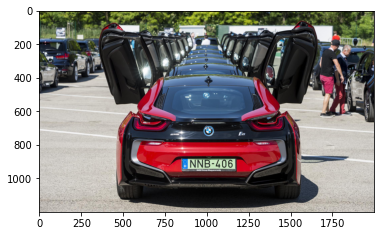

Image Patch Count:  2606
Image Matching Patch Count:  99
FOUND PLATE


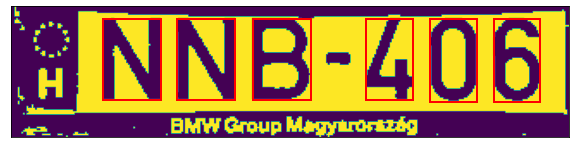

NEXT IMAGE...


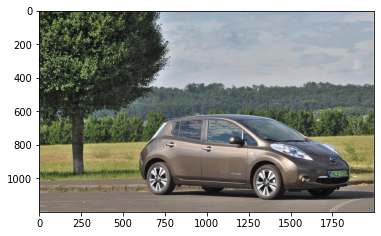

Image Patch Count:  22849
Image Matching Patch Count:  103
FOUND PLATE


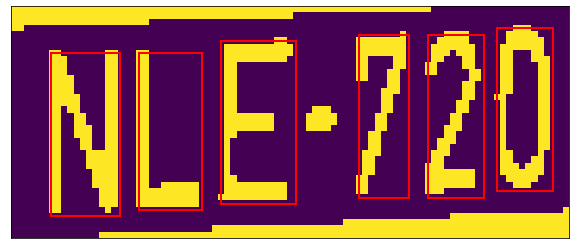

NEXT IMAGE...


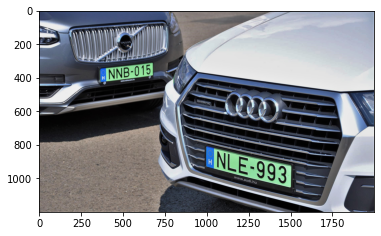

Image Patch Count:  6509
Image Matching Patch Count:  56
FOUND PLATE


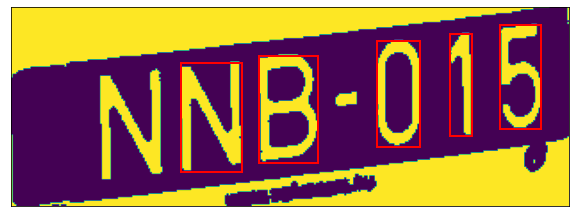

FOUND PLATE


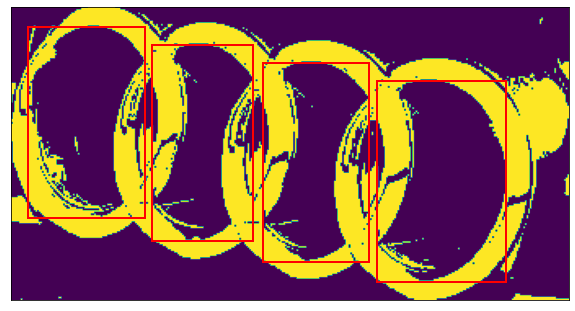

FOUND PLATE


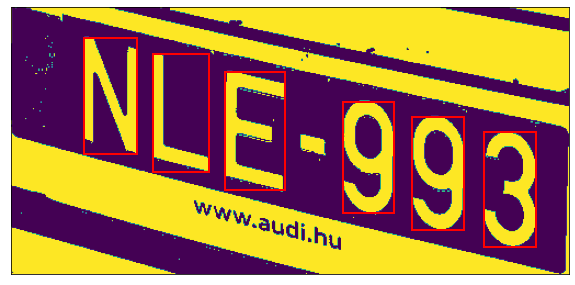

NEXT IMAGE...


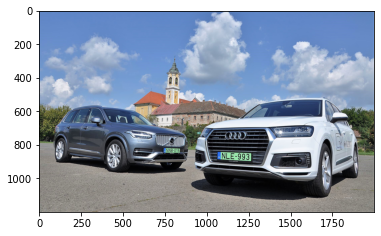

Image Patch Count:  15325
Image Matching Patch Count:  43
FOUND PLATE


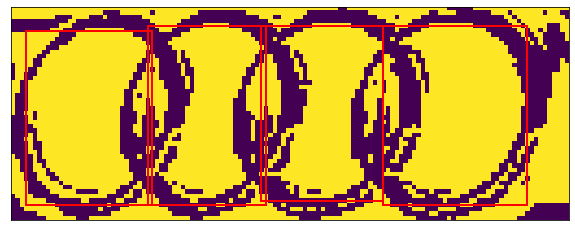

FOUND PLATE


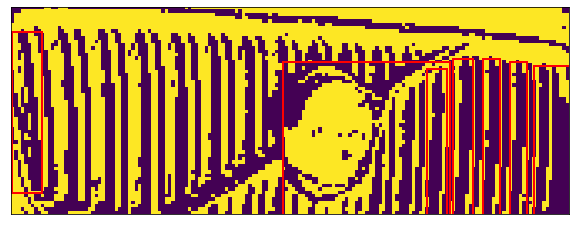

FOUND PLATE


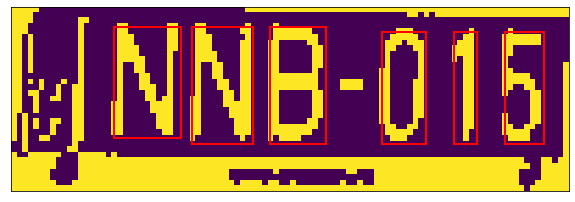

FOUND PLATE


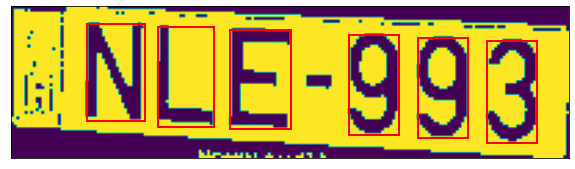

NEXT IMAGE...


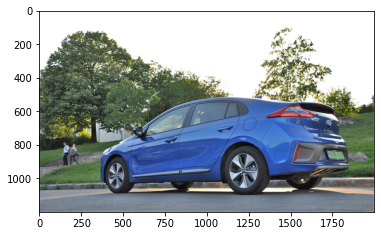

Image Patch Count:  7606
Image Matching Patch Count:  58
NEXT IMAGE...


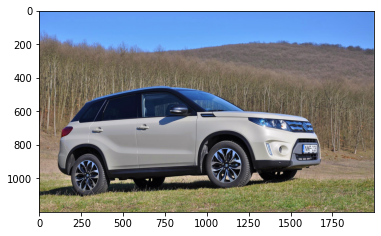

Image Patch Count:  26555
Image Matching Patch Count:  112
FOUND PLATE


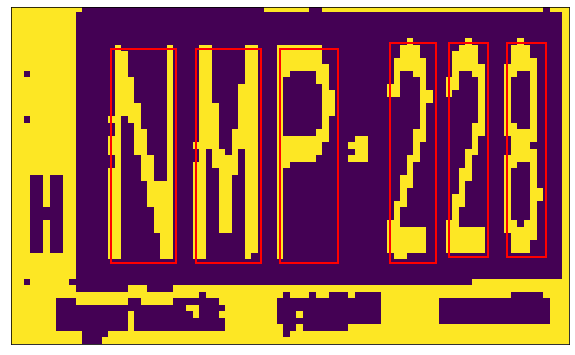

NEXT IMAGE...


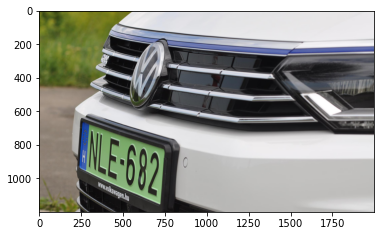

Image Patch Count:  925
Image Matching Patch Count:  25
FOUND PLATE


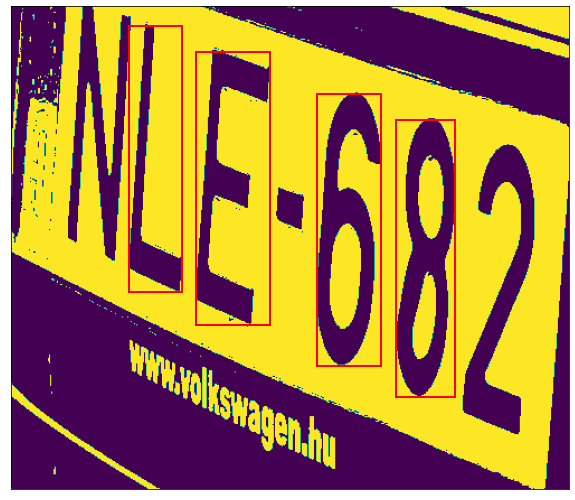

NEXT IMAGE...


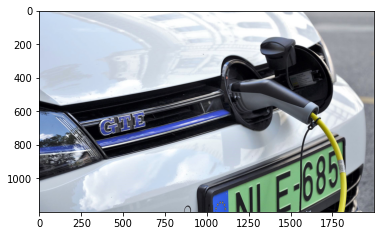

Image Patch Count:  2765
Image Matching Patch Count:  49
NEXT IMAGE...


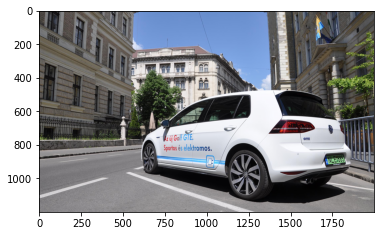

Image Patch Count:  13667
Image Matching Patch Count:  93
FOUND PLATE


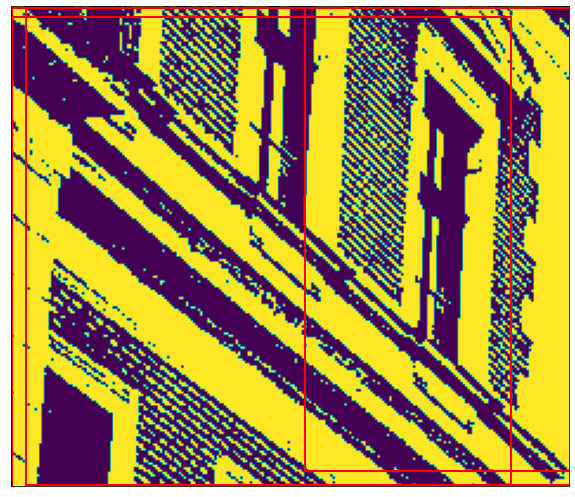

NEXT IMAGE...


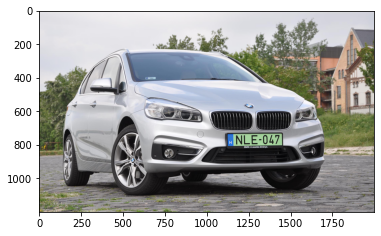

Image Patch Count:  6864
Image Matching Patch Count:  118
FOUND PLATE


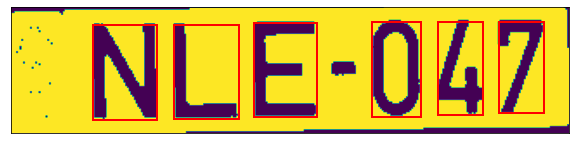

NEXT IMAGE...


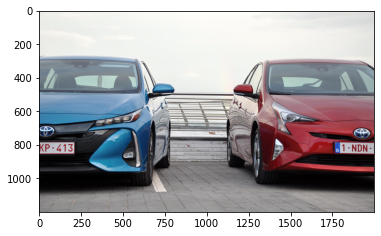

Image Patch Count:  4148
Image Matching Patch Count:  80
FOUND PLATE


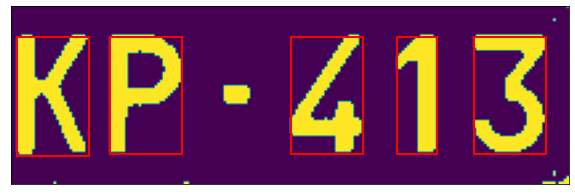

FOUND PLATE


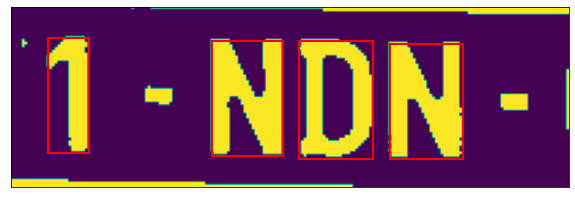

NEXT IMAGE...


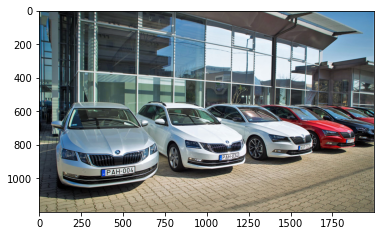

Image Patch Count:  6271
Image Matching Patch Count:  148
FOUND PLATE


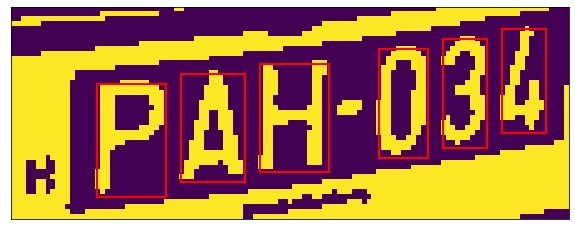

In [39]:
files = ["BMW_Electrictour_0001.jpg", "DSC_0313.jpg", "DSC_2135.jpg",
        "DSC_2144.jpg", "DSC_4709.jpg", "DSC_4979.jpg", "DSC_6923.jpg", "DSC_7358.jpg",
        "DSC_7466.jpg", "DSC_7687.jpg", "DSC_9279.jpg", "Skoda_Miskolc_2017.03.jpg"]

# files = ["DSC_2135.jpg"]

for f in files:
  print("NEXT IMAGE...")

  # Get Image
  img = mpimg.imread(f)
  imgplot = plt.imshow(img)
  plt.show()

  # K-Means Clustering
  img_shape = (img.shape[0], img.shape[1])
  rgb = img.reshape((-1,3))
  kmeans = sklearn.cluster.KMeans(n_clusters = 2).fit(rgb)

  pred = kmeans.predict(rgb)
  res = pred.reshape(img_shape)
  np.shape(res)

  regions = measure.label(res, connectivity = 1, background = -10)
  patches = measure.regionprops(regions)

  print('Image Patch Count: ', len(patches))

  matching_patches = find_image_matching_patches(patches)

  print('Image Matching Patch Count: ', len(matching_patches))

  for point in matching_patches:
    (x, y), w, h = point
    plate = img[y:y+h,x:x+w]

    # K-Means Clustering
    plate_shape = (plate.shape[0], plate.shape[1])
    plate_rgb = plate.reshape((-1,3))

    kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(plate_rgb)

    plate_pred = kmeans.predict(plate_rgb)
    plate_res = plate_pred.reshape(plate_shape)

    plate_regions = measure.label(plate_res, connectivity = 1, background = -10)
    plate_patches = measure.regionprops(plate_regions)

    plate_matching_patches = find_plate_matching_patches(plate_patches, plate_res)

    # Check for Patch Count Range
    if len(plate_matching_patches) < 4 or len(plate_matching_patches) > 10:
     continue
      
    print('FOUND PLATE')
    plot_image_with_patches(plate_res, plate_matching_patches)
    


